# Classification Notebook
## Logistic Regression

This is the main notebook used to create my models for detecting harmful comments in a corpus of comments from r/soccer subreddit. 

Plan of action: 
1. Load and Explore the Data
    - **Statistics:** Understand the dataset dimensions, data types and missing values
    - **Class Distribution:** Determine the extent of imbalance in my dataset
    - **Text Exploration:** Check for common words, slang and noise in the text
2. Data Preprocessing
    - **Cleaning Text:** Remove stopwords, non-alphabetic characters, URLS
    - **Feature Engineering:**
        - TF-IDF & Stemming
        - Word2Vec
        - Lexical Features (Count of words, sentence length, punctuation usage)
        - Topic Modeling
3. Split the Data
4. Initial Model Training with Tuning
    - Logistic Regression
5. Advanced Feature Engineering
    - Explore if combination of words or features increase predicitons performance
    - N-grams 
6. Address the Imbalance
    - Oversampling minority class (SMOTE)
    - Undersampling the majority class
    - Stratified KFold
7. Final GridSearch

***

In [ ]:
# In order to import required libraries and tools, you may need to run this
# cell in order to install all dependencies
!pip install pandas matplotlib wordcloud numpy seaborn nltk scikit-learn gensim scipy xgboost imbalanced-learn

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [1]:
# Imports for Data Exploration
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
import numpy as np
import seaborn as sns

# Imports for Data Preprocessing
import nltk
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from scipy.sparse import hstack, csr_matrix

# Imports for Data Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Imports for Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


# Imports for Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold


# Imports for Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Load and Explore the Dataset

In [2]:
# Loading the dataset
data_path = 'data.csv'
data = pd.read_csv(data_path)

In [3]:
# Looking at the head of dataframe
data.head()

,id,comment,score,sentiment
0,1,"What happened to sevilla, seriously?",1,0
1,2,is tom huddlestone right or left footed?,1,0
2,3,How highly rated was Deivid Washington at Sant...,1,0
3,4,Yeah I thought you guys would go for more high...,1,0
4,5,Never judge a player based on such limited gam...,1,0


In [4]:
dimension = data.shape
data_types = data.dtypes
missing_values = data.isnull().sum()

dimension, data_types, missing_values

((19282, 4),
 id            int64
 comment      object
 score         int64
 sentiment     int64
 dtype: object,
 id           0
 comment      0
 score        0
 sentiment    0
 dtype: int64)

## Summary of our statistics

**Dimensions** - The dataset contains 19,282 rows with 4 columns
**Data Types** - id, score and sentiment are a floating point number, comment is a string
**Missing values** - 0 missing values
***

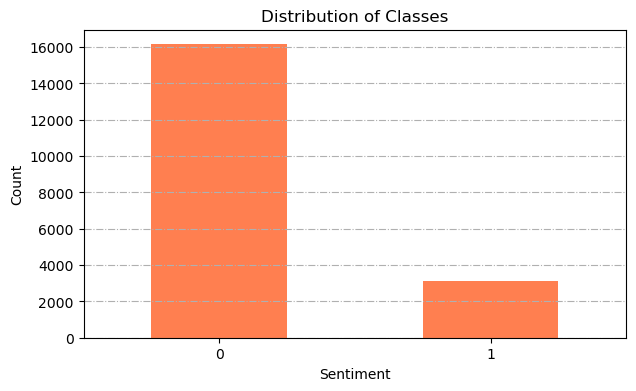

sentiment
0    16151
1     3131
Name: count, dtype: int64

In [6]:
# Class Distribution in the dataset
class_distribution = data['sentiment'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(7, 4))
class_distribution.plot(kind='bar', color='coral')
plt.title('Distribution of Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='dashdot')
plt.show()

class_distribution

This shows a significant imbalance in our dataset with 16,151 comments being non-harmful and 3,131 comments being harmful.
***

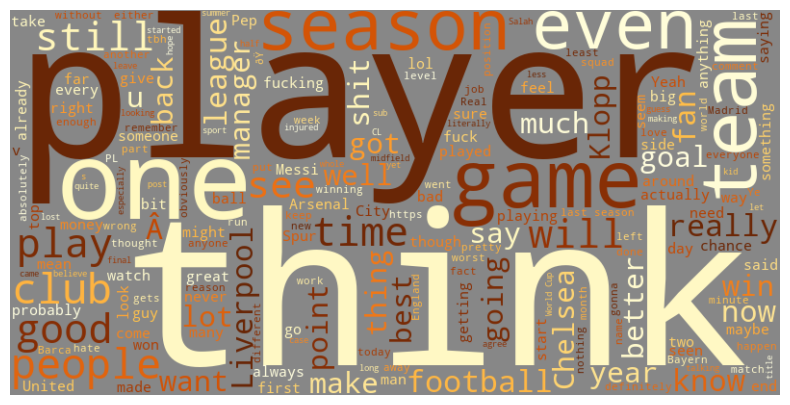

In [7]:
# Combine comments into a single string
all_comments = ' '.join(data['comment'].astype(str))

# Word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='#878787', colormap='YlOrBr').generate(all_comments)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
# Clean and Tokenize text
def tokenize(text):
    tokens = re.findall(r"\b\w[\w']*\b", text.lower())
    return tokens

# Tokenize comments
tokens = [tokenize(comment) for comment in data['comment']]
all_tokens = [token for sublist in tokens for token in sublist]
token_counts = Counter(all_tokens)

# Display the most common words
most_common_words = token_counts.most_common(20)
print("Most common words:", most_common_words)

Most common words: [('the', 21234), ('a', 13466), ('to', 11737), ('and', 10682), ('of', 8593), ('in', 8457), ('i', 7488), ('is', 7254), ('that', 6475), ('for', 5791), ('he', 5417), ('it', 5372), ('but', 4678), ('you', 4266), ('was', 3945), ('be', 3663), ('not', 3499), ('on', 3333), ('with', 3185), ('have', 3138)]


## Analysis of Common Words

The most common words in the dataset are typical stop words such as "the", "a", "to" and "and". These do not provide the models into much insight as to whether the comments are harmful or not. During my data preprocessing it will be therefore worth removing these stopwords. 
***
# Data Preprocessing
As well as removing stop words, I will also remove URLs, numbers, non-word characters and punctuation as again they do not add anything value.

In [42]:
# Basic Text Cleaning
def clean_text(text):
    text = text.lower() #lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)#urls
    text = re.sub(r'[^\w\s]', '', text)#non-word characters
    text = re.sub(r'[\.\,\'\"\!\?\:\;\-\=]', ' ', text)#punctuation
    text = re.sub(r'\d+', '', text)#numbers
    stop_words = set(stopwords.words('english'))#stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply function to comment column in data and display head of clean comments
data['clean_comment'] = data['comment'].apply(clean_text)
data[['comment', 'clean_comment']].head()

,comment,clean_comment
0,"What happened to sevilla, seriously?",happened sevilla seriously
1,is tom huddlestone right or left footed?,tom huddlestone right left footed
2,How highly rated was Deivid Washington at Sant...,highly rated deivid washington santos two came...
3,Yeah I thought you guys would go for more high...,yeah thought guys would go high profile well k...
4,Never judge a player based on such limited gam...,never judge player based limited gametime


## Feature Engineering

- TF-IDF & Stemming
- Word2Vec
- Lexical Features - I will be creating 3 new features, for Word Count, Character Count and Average Word Length
- Topic Modeling using LDA to create 5 topics

In [10]:
# Function to apply stemming
def stem_text(data, column_name):
    stemmer = PorterStemmer()
    stemmed_texts = [' '.join(stemmer.stem(word) for word in text.split()) for text in data[column_name]]
    return stemmed_texts

data['stemmed_comment'] = stem_text(data, 'clean_comment')

In [11]:
data[['comment', 'stemmed_comment']].head()

,comment,stemmed_comment
0,"What happened to sevilla, seriously?",happen sevilla serious
1,is tom huddlestone right or left footed?,tom huddleston right left foot
2,How highly rated was Deivid Washington at Sant...,highli rate deivid washington santo two cameo ...
3,Yeah I thought you guys would go for more high...,yeah thought guy would go high profil well kno...
4,Never judge a player based on such limited gam...,never judg player base limit gametim


In [12]:
# Initialize vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

In [13]:
# Combine clean and stemmed comments into a single corpus for fitting
combined_corpus = pd.concat([data['clean_comment'], data['stemmed_comment']])

# Fit the vectorizer on the combined corpus
tfidf_vectorizer.fit(combined_corpus)

TfidfVectorizer(max_features=1000)

In [14]:
# Transform the clean comments
tfidf_features_clean = tfidf_vectorizer.transform(data['clean_comment'])

# Transform the stemmed comments
tfidf_features_stemmed = tfidf_vectorizer.transform(data['stemmed_comment'])

In [15]:
# Prepare data for Word2Vec and train
text_data = data['clean_comment'].apply(lambda x: x.split())
w2v_model = Word2Vec(text_data, vector_size=100, window=5, min_count=2, workers=4)

# Vectorize comment based on the word vectors
def vectorize_comment(text, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in text:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Transform each comment into a vector and make sure format correct for concatenation
data['w2v_features'] = data['clean_comment'].apply(lambda x: vectorize_comment(x.split(), w2v_model))
w2v_matrix = np.array(data['w2v_features'].tolist())

In [16]:
# Lexical features: Word Count, Character Count and Average Word Length
# with a condition to avoid division by zero so no NaN values in data
data['word_count'] = data['clean_comment'].apply(lambda x: len(x.split()))
data['char_count'] = data['clean_comment'].apply(len)
data['avg_word_length'] = data.apply(lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)

lexical_features = data[['word_count', 'char_count', 'avg_word_length']].values

In [17]:
# Topic Modeling with 5 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_features = lda_model.fit_transform(tfidf_features_clean)
data['dominant_topic'] = np.argmax(lda_features, axis=1)

## Visualisation of New Features

#### TF-IDF Top 20 N-Grams for Harmful Comments

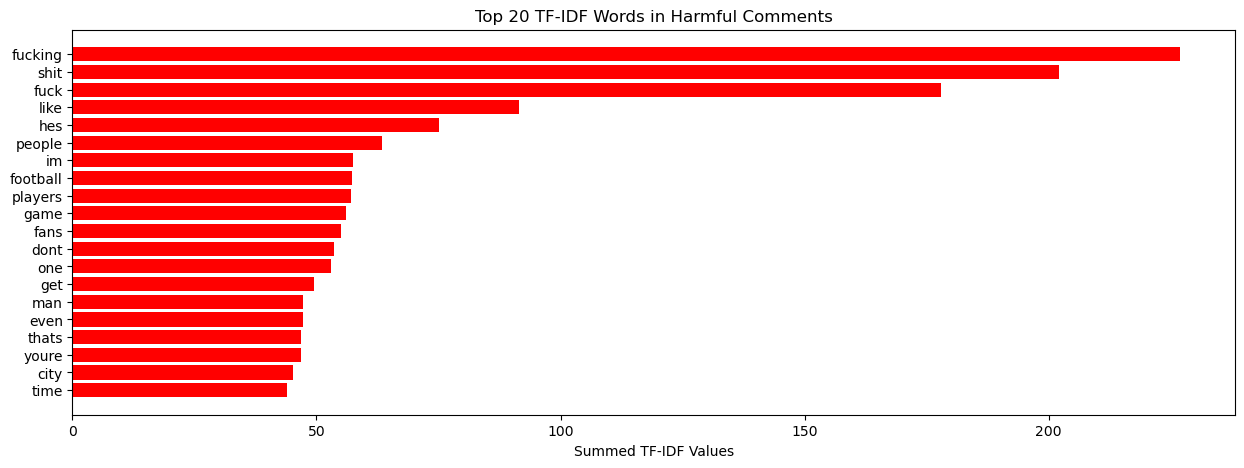

In [21]:
#Get indices for harmful comments
harmful_comments_idx = data[data['sentiment'] == 1].index

# Sum the TF-IDF scores for harmful comments and convert to array
summed_tfidf_harmful = tfidf_features_clean[harmful_comments_idx].sum(axis=0)
summed_tfidf_harmful_array = np.array(summed_tfidf_harmful).flatten()

# Get feature names and indices of top N features
feature_names = tfidf_vectorizer.get_feature_names_out()
top_n = 20
sorted_indices_harmful = np.argsort(summed_tfidf_harmful_array)[-top_n:]

# Plot
plt.figure(figsize=(15, 5))
plt.barh(range(top_n), summed_tfidf_harmful_array[sorted_indices_harmful], color='red')
plt.yticks(range(top_n), [feature_names[i] for i in sorted_indices_harmful])
plt.title('Top 20 TF-IDF Words in Harmful Comments')
plt.xlabel('Summed TF-IDF Values')
plt.show()

#### Histogram of Word Count and Box Plot of Average Word Length

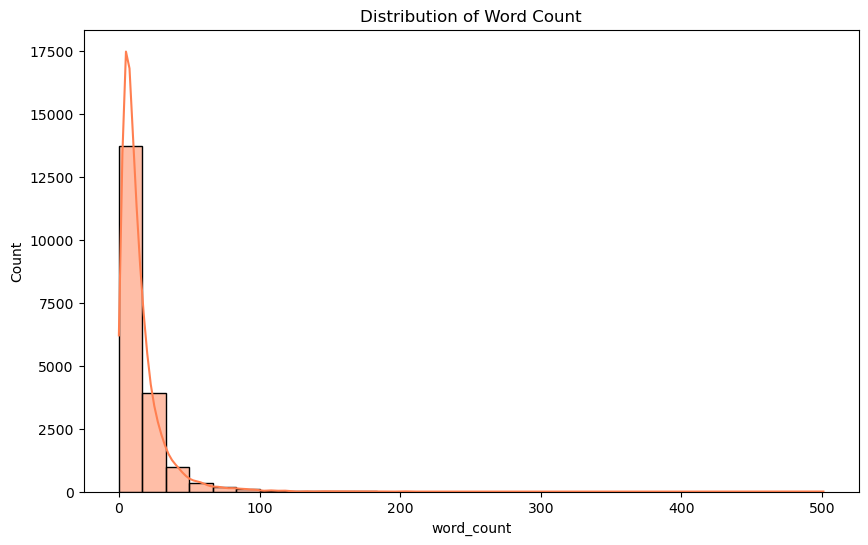

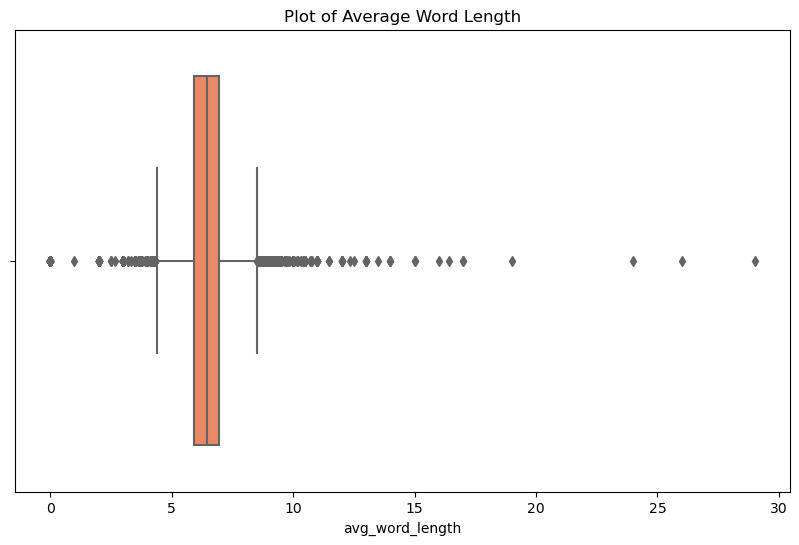

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(data['word_count'], bins=30, kde=True, color='coral')
plt.title('Distribution of Word Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=data['avg_word_length'], color='coral')
plt.title('Plot of Average Word Length')
plt.show()

#### Findings
1. Distribution of word count shows most comments contain relatively few words and only a few comments with a very high word count
2. The central line in the box represents the median average of word length. Showing that there are some outliers skewed towards a high average word length.

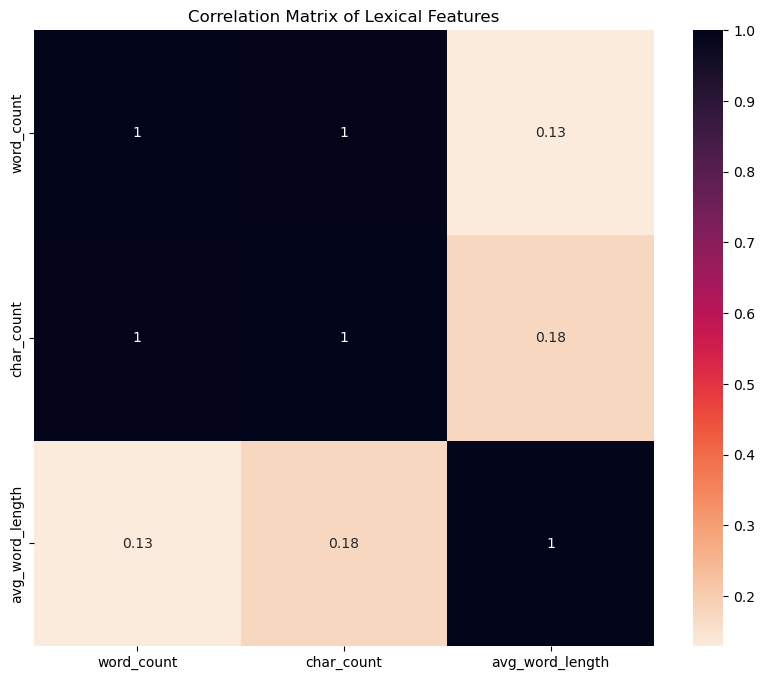

In [19]:
# Correlation matrix: Lexical Features
feature_cols = ['word_count', 'char_count', 'avg_word_length']
correlation_matrix = data[feature_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket_r')
plt.title('Correlation Matrix of Lexical Features')
plt.show()

#### Findings:
As expected character count is highly correlated with word count as more words will likely mean more characters. There is a weak correlation to the average word length. 

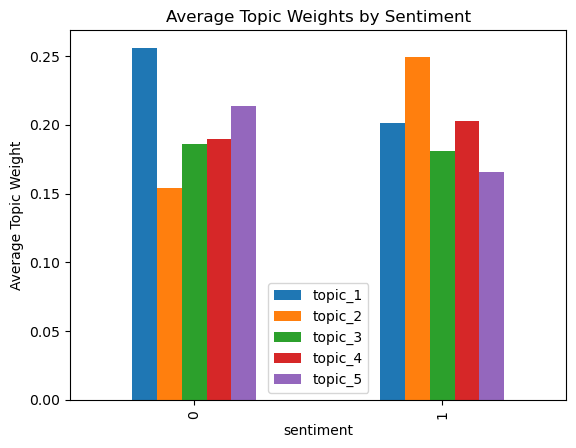

In [20]:
# DataFrame for the LDA topic distribution matrix
topics_df = pd.DataFrame(lda_features, columns=['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5'])

# Concatenate topic distribution with the original data
data_with_topics = pd.concat([data.reset_index(drop=True), topics_df], axis=1)

# Analyse distribution by sentiment
data_with_topics.groupby('sentiment')[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].mean().plot(kind='bar')
plt.title('Average Topic Weights by Sentiment')
plt.ylabel('Average Topic Weight')
plt.show()

#### Findings

Topic 2 more prevalent in harmful comments and less so for topic 1, 3 and 5. Topic 4 has a similar weight across the two classes.
***
# Split the Data

## Firstly, only with TF-IDF & Stemming

In [23]:
tfidf_features_matrix = hstack([
    tfidf_features_clean,
    tfidf_features_stemmed,
])

In [24]:
target = data['sentiment'].values

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    tfidf_features_matrix,
    target,  
    test_size=0.2,
    random_state=42,
    stratify=target
)

#### Basic Logistic Regression model
Class Weight is balanced but no other further parameter tuning

In [25]:
# Basic Logistic Regression model with TF-IDF
logreg_tfidf = LogisticRegression(random_state=42, class_weight='balanced')
logreg_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Predict and Evaluate
y_pred_tfidf  = logreg_tfidf.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_pred_tfidf ))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3231
           1       0.57      0.71      0.63       626

    accuracy                           0.86      3857
   macro avg       0.75      0.80      0.77      3857
weighted avg       0.88      0.86      0.87      3857



# Split the Data
## With Combined Features
(Word2Vec, Lexical Features, LDA topic)

In [26]:
# Stack all features horizontally
combined_features = np.hstack((w2v_matrix, lexical_features, lda_features))

In [27]:
# Splitting the combined features
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    combined_features,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

#### Basic LR Model
Again just class weight is balanced, no other further tuning

In [28]:
# Basic Logistic Regression model with combined features
logreg_combined = LogisticRegression(random_state=42, class_weight='balanced')
logreg_combined.fit(X_train_combined, y_train_combined)

# Predict and Evaluate
y_pred_combined  = logreg_combined.predict(X_test_combined)
print(classification_report(y_test_combined, y_pred_combined ))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      3231
           1       0.31      0.64      0.42       626

    accuracy                           0.71      3857
   macro avg       0.61      0.68      0.61      3857
weighted avg       0.81      0.71      0.74      3857



C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Looking at feature importance
Identifying the most important features from the data that has been vectorized using the TF-IDF vectorizer

In [29]:
feature_importance_lr = np.abs(logreg_tfidf.coef_[0])
feature_names_lr = tfidf_vectorizer.get_feature_names_out()
features_lr = sorted(zip(feature_importance_lr, feature_names_lr), reverse=True)

# Display top 10 important features
print("Top 10 important features for Logistic Regression (TF-IDF):")
for importance, name in features_lr[:10]:
    print(f"{name}: {importance:.4f}")

Top 10 important features for Logistic Regression (TF-IDF):
shit: 9.5503
fucking: 5.9156
fuck: 5.1914
shite: 4.7604
cunt: 2.8787
piss: 2.3894
give: 1.9859
keep: 1.9647
rapist: 1.8371
considering: 1.8052


### Findings: 
It's clear that profane words have a high feature importance in the better perfoming TF-IDF models. Therefore, it's a suitable next to look at using this further to create better features.
***
# Advanced NLP Techniques

## N-Grams
Two vectorizers: One for Words with range 1,3 and another for characters range 2,6

In [30]:
# Word-level TF-IDF
tfidf_vectorizer_words = TfidfVectorizer(max_features=1000, analyzer='word', ngram_range=(1,3))
tfidf_features_words = tfidf_vectorizer_words.fit_transform(data['clean_comment'])

# Character-level TF-IDF
tfidf_vectorizer_chars = TfidfVectorizer(max_features=1000, analyzer='char', ngram_range=(2,6))
tfidf_features_chars = tfidf_vectorizer_chars.fit_transform(data['clean_comment'])

***
## Creating a Profanity Count feature
Creating a profanity feature by concatenating all strings for harmful and non harmful comments. Use a counter then to find the frequency of words. Name these columns. Once mrged they can be sorted from highest to lowest frequency displaying the difference between harmful and non harmful and print the top 20.

In [31]:
# Extract all words from harmful and non-harmful comments
harmful_comments_words = ' '.join(data[data['sentiment'] == 1]['clean_comment']).split()
non_harmful_comments_words = ' '.join(data[data['sentiment'] == 0]['clean_comment']).split()

# Create frequency distributions
harmful_word_freq = Counter(harmful_comments_words)
non_harmful_word_freq = Counter(non_harmful_comments_words)

# Convert to dataframes for easier manipulation
harmful_df = pd.DataFrame(harmful_word_freq.items(), columns=['Word', 'Harmful_Freq'])
non_harmful_df = pd.DataFrame(non_harmful_word_freq.items(), columns=['Word', 'Non_Harmful_Freq'])

# Merge dataframes on the words
merged_df = pd.merge(harmful_df, non_harmful_df, on='Word', how='left')

# Fill NaN values with 0 - words that appear in harmful but not non-harmful comments
merged_df['Non_Harmful_Freq'] = merged_df['Non_Harmful_Freq'].fillna(0)

# Calculate and sort the difference in frequencies
merged_df['Freq_Difference'] = merged_df['Harmful_Freq'] - merged_df['Non_Harmful_Freq']
merged_df = merged_df.sort_values(by='Freq_Difference', ascending=False)

# Filter out words that are more frequent in non-harmful comments
profane_potential_words = merged_df[merged_df['Freq_Difference'] > 0]

# Show the top words that could potentially be profane
profane_potential_words.head(20)

,Word,Harmful_Freq,Non_Harmful_Freq,Freq_Difference
106,shit,706,0.0,706.0
28,fucking,585,0.0,585.0
79,fuck,486,0.0,486.0
1224,fucked,89,0.0,89.0
712,shite,80,0.0,80.0
56,cunt,60,0.0,60.0
59,piss,47,0.0,47.0
2271,shitty,34,0.0,34.0
2378,crap,32,0.0,32.0
1579,bullshit,29,0.0,29.0


Now to create a column "profanity count" that can add how many of these swear words are in the comment.

In [32]:
# List of identified profane words
profane_words = [
    'shit', 'fucking', 'fuck', 'fucked', 'shite',
    'cunt', 'piss', 'shitty', 'crap', 'bullshit',
    'fucks', 'pissed', 'twat', 'dick', 'cunts',
    'holy', 'shitting', 'sex', 'bastard', 'wank'
]

# Count the occurrences of profane words
def count_profanity(text, profane_words):
    return sum(text.count(word) for word in profane_words)

data['profanity_count'] = data['clean_comment'].apply(lambda x: count_profanity(x, profane_words))

In [33]:
# Combine Profanity Count
profanity_features = data['profanity_count'].values.reshape(-1, 1)
profanity_features = csr_matrix(profanity_features.reshape(-1, 1))

***
# Splitting the data with the new features

In [34]:
new_features_matrix = hstack([tfidf_features_words, tfidf_features_chars, tfidf_features_stemmed, profanity_features])

In [35]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    new_features_matrix,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

#### Basic model again to test new features

In [36]:
# Logistic Regression model with new features
logreg_tfidf_new = LogisticRegression(random_state=42, class_weight= None)
logreg_tfidf_new.fit(X_train_new, y_train_new)

# Predict and Evaluate
y_pred_new  = logreg_tfidf_new.predict(X_test_new)
print(classification_report(y_test_new, y_pred_new ))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3231
           1       0.98      0.70      0.82       626

    accuracy                           0.95      3857
   macro avg       0.96      0.85      0.89      3857
weighted avg       0.95      0.95      0.95      3857



### Findings:
The model has significantly improved with the implementation of n-grams and the profanity count feature. I can now look at addressing the imbalance in the dataset. 
***
# Addressing the Imbalance in the Dataset
## SMOTE

In [37]:
# Apply SMOTE to generate synthetic samples for the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_new, y_train_new)

In [38]:
# Logistic Regression model with new features and SMOTE
logreg_smote = LogisticRegression(random_state=42)
logreg_smote.fit(X_train_smote, y_train_smote)

# Predict and Evaluate
y_pred_smote  = logreg_smote.predict(X_test_new)
print(classification_report(y_test_new, y_pred_smote))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3231
           1       0.76      0.75      0.75       626

    accuracy                           0.92      3857
   macro avg       0.85      0.85      0.85      3857
weighted avg       0.92      0.92      0.92      3857



## Random Undersampling

In [39]:
# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_train_rus, y_train_rus = rus.fit_resample(X_train_new, y_train_new)

In [40]:
# Logistic Regression model with new features and RUS
logreg_rus = LogisticRegression(random_state=42)
logreg_rus.fit(X_train_rus, y_train_rus)

# Predict and Evaluate
y_pred_rus  = logreg_rus.predict(X_test_new)
print(classification_report(y_test_new, y_pred_rus))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3231
           1       0.72      0.76      0.74       626

    accuracy                           0.91      3857
   macro avg       0.84      0.85      0.85      3857
weighted avg       0.92      0.91      0.92      3857



***
# GridSearch for Logistic Regression
#### Using no balancing technique

In [41]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2', 'elasticnet'], 
    'solver': ['liblinear', 'saga'], 
    'class_weight': [None, 'balanced', {0: 1, 1: 10}, {0: 1, 1: 5}] 
}

# Initialize the Logistic Regression model and the GridSearchCV object
logreg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(
    logreg, 
    param_grid, 
    cv=StratifiedKFold(n_splits=5), 
    scoring='f1', 
    verbose=1, 
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_new, y_train_new)

# Best model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_new)
print(classification_report(y_test_new, y_pred))

Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver 

Best parameters: {'C': 0.001, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.82
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3231
           1       0.99      0.70      0.82       626

    accuracy                           0.95      3857
   macro avg       0.97      0.85      0.89      3857
weighted avg       0.95      0.95      0.95      3857



In [33]:
import joblib
joblib.dump((best_model, tfidf_vectorizer_words, tfidf_vectorizer_chars, tfidf_features_stemmed), 'lr_model_and_vectorizers.pkl')

['lr_model_and_vectorizers.pkl']

# Results:

The Logistic Regression was to serve as a foundation for the three models being the simplest of them all and with little in the way of tuning. The final gridsearch did not improve on the earlier model that was trained to test the new features. The outcome of the models performance for the minority class was:
- Precision: 0.99
- Recall: 0.70
- F1: 0.82

Sadly the recall does imply that we are not catching all harmful comments which would be ideal for the project. With more time and computational power it would be worth running an even larger GridSearch and testing more variety of features 